# Uma Análise de Dados Sobre O Sistema Único de Saúde (SUS) Brasileiro

# Introdução

O Sistema Único de Saúde (SUS) brasileiro é o maior sistema de saúde pública, universal, descentralizado e igualitário gerenciado por um governo no mundo.[[1]](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(19)31243-7/fulltext#articleInformation) Criado para garantir o direito universal à saúde, presente na Constituição de 1988, o SUS tem como objetivos principais regulamentar, supervisionar, garantir e fornecer todo um aparato relacionado à saúde pública no Brasil, incluíndo não só procedimentos hospitalares, mas também atividades como controle e fiscalização de água e alimentos, e desenvolvimento científico.[[2]](http://www.planalto.gov.br/ccivil_03/leis/l8080.htm)

Na atual pandemia do Covid-19, o SUS vem sofrendo de uma crise gerada por superlotação de leitos e falta de investimentos do Governo Federal.[[3]](https://www.ceen.com.br/os-6-maiores-desafios-que-a-saude-publica-do-brasil-vem-enfrentando/) Essas dificuldades só escancaram ainda mais a importância de um país continental como o Brasil possuir um Sistema Único de Saúde de qualidade, que atinja todas as regiões igualmente.

É nesse contexto que faremos nossa análise de dados, tentando entender como o número de internações e o total de gastos estão relacionados. Partimos de uma análise mais geral e chegamos em uma análise mais específica, iniciando pelo contexto do país inteiro, depois dividindo por regiões e finalmente analisando um só Estado. Para isso, foi escolhida a Região Nordeste do Brasil e o Estado do Ceará para receberem um estudo mais aprofundado.

# Descrição dos Dados

O SUS possui um sistema próprio de informática para processar e manter dados e informações sobre diversos indicadores de saúde e informações financeiras, o [DATASUS](https://datasus.saude.gov.br/).

No DATASUS temos o sistema [TABNET](http://www2.datasus.gov.br/DATASUS/index.php?area=02), que tem como finalidade permitir às equipes técnicas do Ministério da Saúde, das Secretarias Estaduais de Saúde e das Secretarias Municipais de Saúde a realização de tabulações rápidas sobre os dados presentes nos Sistemas de Informações do Sistema Único de Saúde.[[4]](http://www2.datasus.gov.br/DATASUS/index.php?area=060804)

Com isso em mente, vamos à parte técnica dos dados utilizados.

**Caminho dos Dados:** [TABNET](http://www2.datasus.gov.br/DATASUS/index.php?area=02) ➔ [Assistência à Saúde](http://www2.datasus.gov.br/DATASUS/index.php?area=0202) ➔ [Produção Hospitalar (SIH/SUS)](http://www2.datasus.gov.br/DATASUS/index.php?area=0202&id=11633) ➔ [Dados Consolidados AIH (RD), por local de internação, a partir de 2008](http://www2.datasus.gov.br/DATASUS/index.php?area=0202&id=11633&VObj=http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sih/cnv/qi) ➔ [Abrangência Geográfica: Brasil por Região e Unidade da Federação](http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sih/cnv/qiuf.def)

Nesta última página foram feitas as seleções:
- **Linha:** Unidade da Federação;
- **Coluna:** Ano/mês atendimento;
- **Conteúdo:** Internações e, em outra procura, valor total;
- **Períodos Disponíveis:** Jan/2008 a Mar/2021;
- **Seleções Disponíveis**: todas com os valores padrão.

Para os munícipios, foi selecionado o Estado do Ceará na área de _Abrangência Geográfica_ e o processo foi basicamente o mesmo.

**Data de Acesso:** 22/05/2021 & 26/05/2021.

Na mesma página encontramos um documento com as [Notas Técnicas](http://tabnet.datasus.gov.br/cgi/sih/Proced_hosp_loc_int_2008.pdf) que nos fornece a **origem dos dados** e a **descrição das variáveis disponíveis para tabulação**. Desse modo, para as variáveis que utilizamos, temos que:

Dado | Descrição
:---|:---
**Internações** | Quantidade de AIH* aprovadas no período, não considerando as de prorrogação (longa permanência). Este é um valor aproximado das internações, pois as transferências e reinternações estão aqui computadas.
**Valor Total** | Valor referente às AIH aprovadas no período. Este valor não obrigatoriamente corresponde ao valor repassado ao estabelecimento, pois, dependendo da situação das unidades, estes recebem recursos orçamentários ou pode haver retenções e pagamentos de incentivos, não aqui apresentados. Portanto, este valor deve ser considerado como o valor aprovado da produção. 

(\*) AIH - Autorização de Internação Hospitalar

# Importação de Bibliotecas & Configurações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import locale
from datetime import datetime

In [2]:
# formatar os números para mostrarem duas casa decimais
pd.options.display.float_format = '{:.2f}'.format

# mudar o idioma para convertermos as colunas para data
locale.setlocale(locale.LC_ALL , 'pt_BR.UTF-8')

# configurações de cores
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# configurações da fonte utilizada nos gráficos
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# Número de Internações - Brasil

Como vimos nas [Notas Técnicas](http://tabnet.datasus.gov.br/cgi/sih/Proced_hosp_loc_int_2008.pdf), essa variável representa a
> Quantidade de Autorização de Internação Hospitalar aprovadas no período, não considerando as de prorrogação (longa permanência). Este é um valor aproximado das internações, pois as transferências e reinternações estão aqui computadas.

Vamos analisar esse dataset inicialmente.

## Carregamento & Limpeza dos Dados

Para cada arquivo _.csv_ utilizado, precisaremos saber o número de linhas do cabeçalho e rodapé para podermos configurar o carregamento de acordo. Para isso, podemos abrir cada arquivo _.csv_ em um leitor de texto qualquer para termos uma noção de qual valor utilizar nos parâmetros ```skiprows``` e ```skipfooter``` da função ```read_csv``` da biblioteca ```Pandas```. Mas nem sempre isso é possível de ser feito, em situações do dia-a-dia. Ainda bem que aqui sim!

In [3]:
# importar o aquivo do número das internações no Brasil
internacoes = pd.read_csv('../data/internacoes_brasil.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 12, thousands = '.', decimal = ',', engine = 'python')

In [4]:
internacoes.head(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
0,11 Rondônia,-,1,-,-,-,-,-,7,42,...,8376,8848,8379,8791,8865,8362,7221,4779,2106,1387140
1,12 Acre,1,-,-,-,-,1,-,5,17,...,3549,3574,3724,3973,3834,3821,3588,2898,1788,637069
2,13 Amazonas,3,2,-,1,-,-,1,59,69,...,15417,15709,15727,15796,15424,16213,16344,10777,6256,2248754


In [5]:
internacoes.tail(3)

,Unidade da Federação,2007/Jan,2007/Fev,2007/Mar,2007/Abr,2007/Mai,2007/Jun,2007/Jul,2007/Ago,2007/Set,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
24,51 Mato Grosso,3,2,-,-,-,1,6,102,320,...,13666,13922,14257,14568,13946,13228,12207,10189,6787,2421359
25,52 Goiás,3,3,-,-,-,3,7,298,812,...,25576,25837,26288,26792,24894,23756,22425,18442,12400,4532259
26,53 Distrito Federal,4,12,1,-,1,1,9,47,281,...,16931,17705,17613,18395,17250,17473,17498,14852,11179,2559110


In [6]:
print('O dataframe \'internacoes\' possui {} linhas e {} colunas.'.format(internacoes.shape[0], internacoes.shape[1]))

O dataframe 'internacoes' possui 27 linhas e 173 colunas.


Como podemos ver acima, logo de cara, existem muitos valores faltantes no início do dataframe, pois os dados foram coletados a partir de 2008, e as colunas anteriores são valores adicionados retroativamente.

Vamos então remover as colunas que se encontram antes de Janeiro de 2008. Para isso vamos encontrar a localização dessa coluna para fazermos um slice.

In [7]:
print('A posição da coluna \'2008/Jan\' é a {}.'.format(internacoes.columns.get_loc('2008/Jan')))

A posição da coluna '2008/Jan' é a 13.


Vamos então remover as colunas antes da posição 13.

In [8]:
# cópia do dataframe original
interns = internacoes.copy()

# colocando a UF como indíce
interns = interns.set_index('Unidade da Federação').rename_axis(None)

# removendo as colunas (até a 12, pois tiramos uma coluna, a da UF)
interns = interns.drop(interns.columns[:12], axis = 1)

In [9]:
interns.head(3)

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,...,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,Total
11 Rondônia,5242,5562,5105,5175,5148,6099,7080,7332,6875,6907,...,8376,8848,8379,8791,8865,8362,7221,4779,2106,1387140
12 Acre,3735,3723,4163,4223,4471,4478,4083,3823,4182,4141,...,3549,3574,3724,3973,3834,3821,3588,2898,1788,637069
13 Amazonas,13628,13828,14869,14323,14904,14578,14936,14413,13346,12602,...,15417,15709,15727,15796,15424,16213,16344,10777,6256,2248754


Agora vamos conferir se temos algum outro valor faltante.

In [10]:
print('Agora o dataframe \'aih\' possui {} linhas e {} colunas.'.format(interns.shape[0], interns.shape[1]))

Agora o dataframe 'aih' possui 27 linhas e 160 colunas.


In [11]:
interns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 11 Rondônia to 53 Distrito Federal
Columns: 160 entries, 2008/Jan to Total
dtypes: int64(160)
memory usage: 34.0+ KB


Utilizando o método ```.info()``` acima vemos que todas as 160 colunas são do tipo ```int64```, então não temos nenhum valor como "-" ou "...", pois, caso tivéssemos, a coluna seria, provavelmente, do tipo ```object```. 

Também percebemos que os Estados estão ordenados por Regiões. Com isso, fica fácil fazer um slice nos dados.

In [12]:
# separar por regiões
norte = interns.index[:7].tolist()
nordeste = interns.index[7:16].tolist()
sudeste = interns.index[16:20].tolist()
sul = interns.index[20:23].tolist()
centro_oeste = interns.index[23:].tolist()

In [13]:
# criar um novo dataset para facilitar a plotagem dos dados
internas = interns.copy()
internas = internas.sort_values(by = 'Total', ascending = False)
internas = internas.drop('Total', axis = 1)
internas.columns = pd.to_datetime(internas.columns, format='%Y/%b')

## Análise Gráfica

Podemos enxergar melhor os valores de cada região através de gráficos. Vamos analisar graficamente o número de internações de cada região do país.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


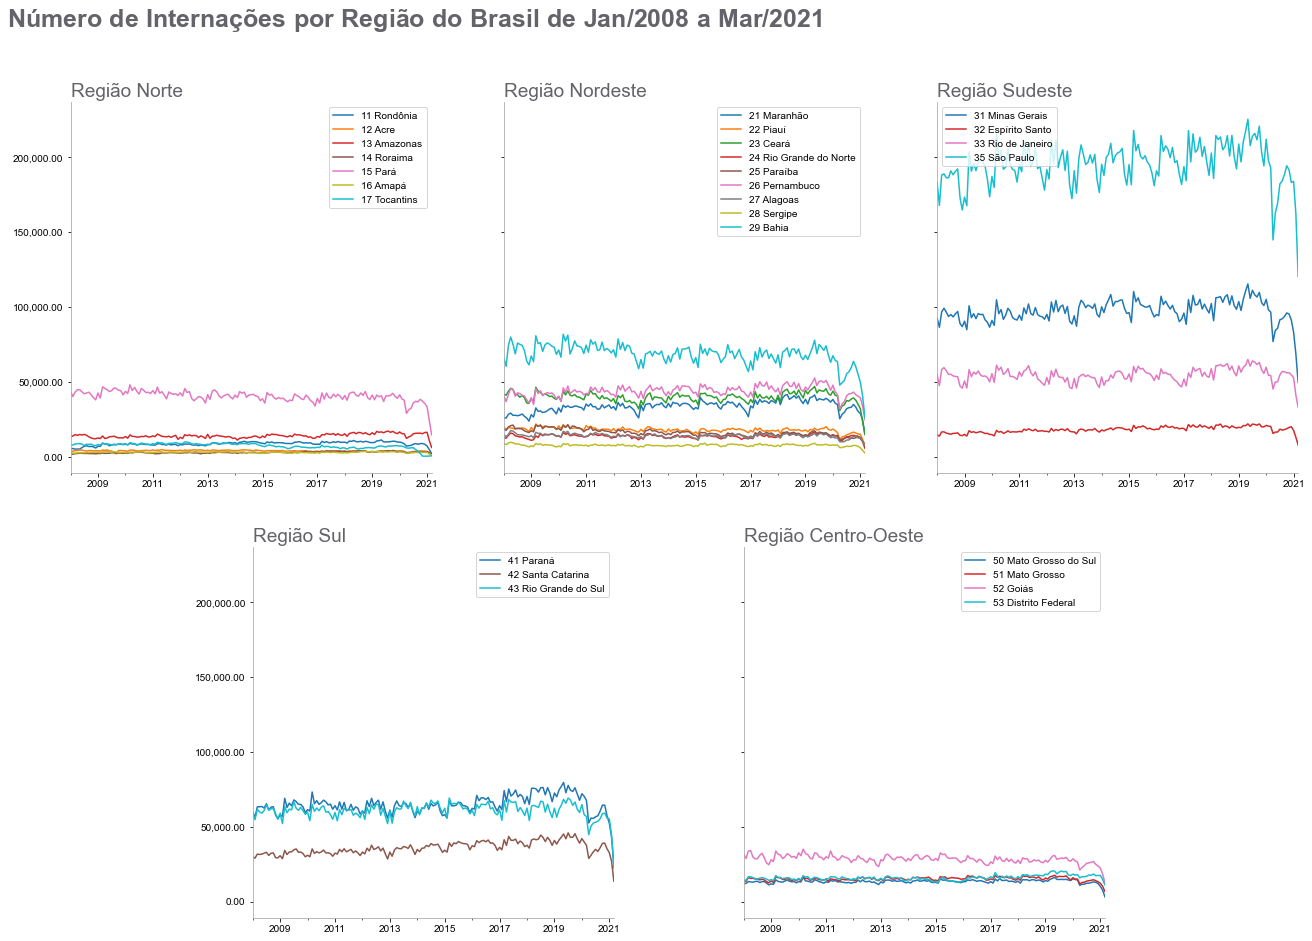

In [14]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (22, 15))

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Região\ do\ Brasil\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

axes[1, 2].set_visible(False)

internas.loc[norte].T.plot(ax = axes[0, 0], colormap = 'tab10')
axes[0, 0].set_title('Região Norte', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
axes[0, 0].spines['bottom'].set_color('darkgrey')
axes[0, 0].spines['left'].set_color('darkgrey')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)

internas.loc[nordeste].T.plot(ax = axes[0, 1], colormap = 'tab10')
axes[0, 1].set_title('Região Nordeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 1].spines['bottom'].set_color('darkgrey')
axes[0, 1].spines['left'].set_color('darkgrey')
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)

internas.loc[sudeste].T.plot(ax = axes[0, 2], colormap = 'tab10')
axes[0, 2].set_title('Região Sudeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 2].spines['bottom'].set_color('darkgrey')
axes[0, 2].spines['left'].set_color('darkgrey')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)

internas.loc[sul].T.plot(ax = axes[1, 0], colormap = 'tab10')
axes[1, 0].set_title('Região Sul', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 0].spines['bottom'].set_color('darkgrey')
axes[1, 0].spines['left'].set_color('darkgrey')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)

internas.loc[centro_oeste].T.plot(ax = axes[1, 1], colormap = 'tab10')
axes[1, 1].set_title('Região Centro-Oeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 1].spines['bottom'].set_color('darkgrey')
axes[1, 1].spines['left'].set_color('darkgrey')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)

axes[1, 0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1, 1].set_position([0.55, 0.125, 0.228, 0.343])

# plt.savefig('a.jpg')

plt.show()

Com todos os gráficos compartilhando o mesmo eixo x e y, a comparação é imediata e aparentemente está tudo certo com os valores, não temos nada muito distante dos demais. Como essa é uma visualização mais geral, não há tanto problema com o fato de alguns estados estarem pouco visíveis. Queremos exergar mais uma visão geral do que o detalhe em si. Faremos isso mais a frente.

Algumas observações que tiramos desse gráfico:
- Há uma sazonalidade no número de internações
    - Iremos observar melhor a seguir em quais períodos as altas e baixas acontecem
- Embora exista uma tendência de queda, ela é muito pouca e há uma certa estabilidade nos valores
- Há uma queda de internações nos últimos meses?
    - Essa queda que existe no final do gráfico deve-se ao fato do ano ainda não estar terminado, então os valores ainda não estão todos colocados para esse período. Podemos remover esses valores ou deixar como está. Optei por deixar do jeito que está.

**Em qual posição do Brasil o Estado do Ceará se encontra no número de internações?**

In [15]:
# o dataset "internas" já está ordenado pelo valor total (somamos 1 pois a contagem se inicia no 0)
print('A posição do Ceará no número de internações no Brasil é: {}.'.format(internas.index.get_loc('23 Ceará') + 1))

A posição do Ceará no número de internações no Brasil é: 9.


In [16]:
internas_total = internas.copy()
internas_total['Soma'] = internas_total.sum(axis = 1)
internas_total['Porcentagem'] = (internas_total['Soma'] / internas_total['Soma'].sum()) * 100

In [17]:
print('A quantidade de internações no Ceará corresponde a {:.2f}% do total do Brasil, \
       \nou seja, {} internações no período de Jan/2008 a  Mar/2021.'.format(internas_total['Porcentagem']['23 Ceará'], internas_total['Soma']['23 Ceará']))

A quantidade de internações no Ceará corresponde a 4.25% do total do Brasil,        
ou seja, 6322342 internações no período de Jan/2008 a  Mar/2021.


In [18]:
# outro dataframe para auxiliar na plotagem
internas = internas.T

In [19]:
internas['Nordeste'] = internas[nordeste].sum(axis = 1)
internas['Norte'] = internas[norte].sum(axis = 1)
internas['Sudeste'] = internas[sudeste].sum(axis = 1)
internas['Sul'] = internas[sul].sum(axis = 1)
internas['Centro_Oeste'] = internas[centro_oeste].sum(axis = 1)

internas = internas[['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_Oeste']]

internas.head()

,Nordeste,Norte,Sudeste,Sul,Centro_Oeste
2008-01-01,249736,79335,345600,148883,72260
2008-02-01,234262,75434,315847,140037,68557
2008-03-01,266151,80410,359802,156629,79740
2008-04-01,283801,82122,364509,154753,79269
2008-05-01,274964,83323,356554,154358,74318


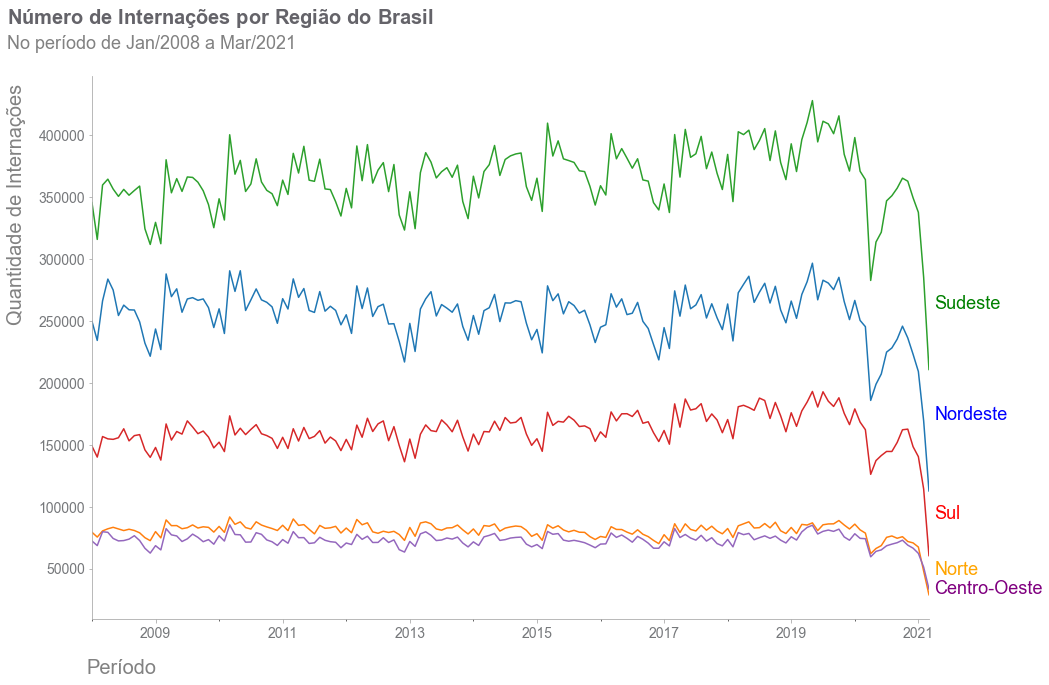

In [20]:
ax = internas.plot(figsize = (15, 10))

ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(440, 490000, '$\\bf{Número\ de\ Internações\ por\ Região\ do\ Brasil}$',
         fontsize = 20, color = GRAY4)
plt.text(440, 470000, 'No período de Jan/2008 a Mar/2021',
         fontsize = 18, color = GRAY6)

plt.text(440, 250000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -35000, 'Período', fontsize = 20, color = GRAY6)

plt.text(615, 260000, 'Sudeste', fontsize = 18, color = 'green')
plt.text(615, 170000, 'Nordeste', fontsize = 18, color = 'blue')
plt.text(615, 90000, 'Sul', fontsize = 18, color = 'red')
plt.text(615, 45000, 'Norte', fontsize = 18, color = 'orange')
plt.text(615, 30000, 'Centro-Oeste', fontsize = 18, color = 'purple')

ax.get_legend().remove()

plt.show()

Graficamente já fica evidente que o Nordeste é a segunda região do país com a maior quantidade de internações no período analisado.

In [21]:
internas = internas.T

In [22]:
internas['Soma'] = internas.sum(axis = 1)
internas['Porcentagem'] = (internas['Soma'] / internas['Soma'].sum()) * 100
internas

,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,...,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,Soma,Porcentagem
Nordeste,249736,234262,266151,283801,274964,254389,262784,259008,258820,249257,...,228178,235284,245788,236280,223116,209180,169271,112705,40595291,27.29
Norte,79335,75434,80410,82122,83323,81990,80693,81766,80745,78874,...,76332,74475,75745,71856,70742,67387,47889,28833,12806923,8.61
Sudeste,345600,315847,359802,364509,356554,350610,356251,351552,355352,358931,...,351134,357234,365316,362872,349480,337705,285158,210757,58101446,39.06
Sul,148883,140037,156629,154753,154358,155674,162895,153145,157368,158185,...,144560,151863,162101,162610,148443,140389,114247,60457,25673670,17.26
Centro_Oeste,72260,68557,79740,79269,74318,72332,72603,73765,76527,72651,...,69731,70889,72909,68909,66493,62276,51154,33515,11589554,7.79


In [23]:
print('A Região Nordeste possui {:.2f}% das internações totais do país no período analisado.'.format(internas['Porcentagem']['Nordeste']))

A Região Nordeste possui 27.29% das internações totais do país no período analisado.


In [24]:
internacoes_nordeste = interns.loc[nordeste].sort_values(by = 'Total', ascending = False)
internacoes_nordeste = internacoes_nordeste.drop('Total', axis = 1)
internacoes_nordeste.columns = pd.to_datetime(internacoes_nordeste.columns, format='%Y/%b')

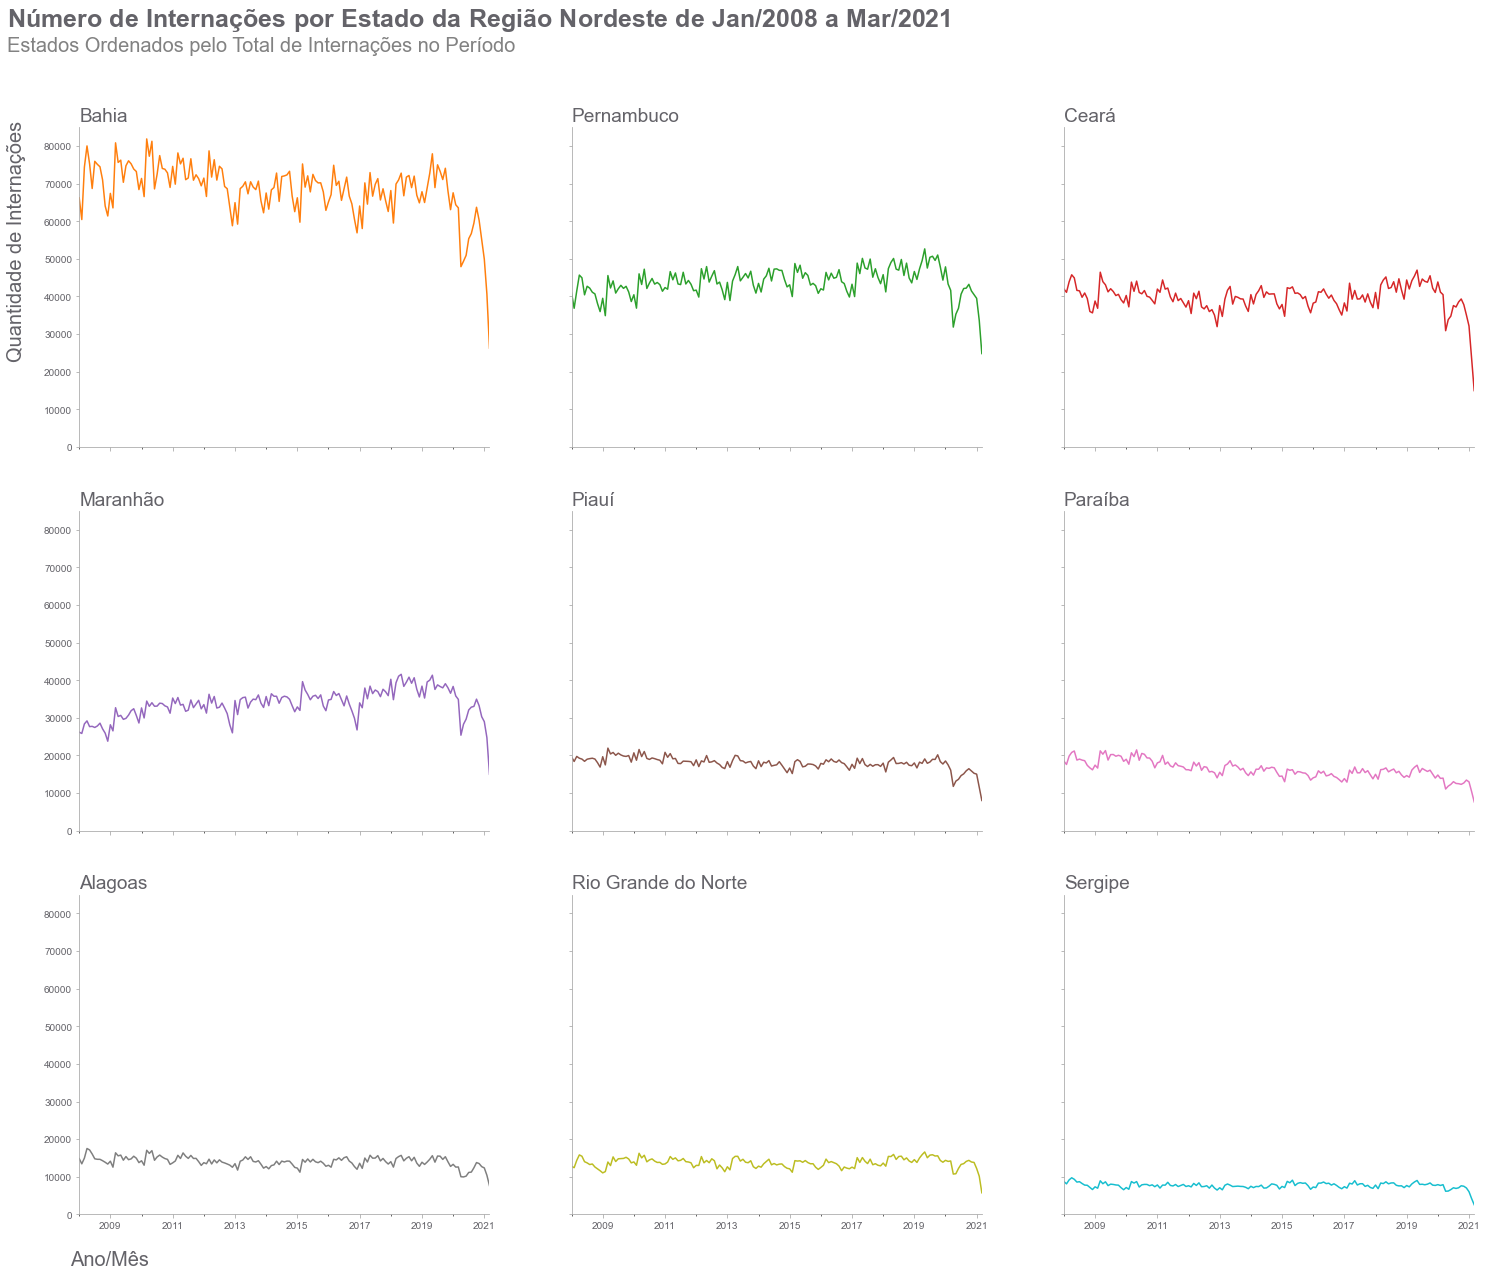

In [25]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (25, 20))

palette = plt.get_cmap('tab10')

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Estado\ da\ Região\ Nordeste\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
fig.text(0.085, 0.933, 'Estados Ordenados pelo Total de Internações no Período',
         fontsize = 20, color = GRAY6)

fig.text(0.085, 0.72, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

num = 0

for estado in internacoes_nordeste.index.tolist():
    num += 1
    plt.subplot(3, 3, num)
    ax = internacoes_nordeste.loc[estado].T.plot(color = palette(num))
    plt.ylim(0,85000)
    if num in range(7) :
        plt.tick_params(labelbottom = False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft = False)
    plt.title(estado[3:], loc = 'left', fontsize = 19, color = GRAY4)
    
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(10)
        i.set_color(GRAY4)
    
    ax.tick_params(color = 'darkgrey')
    ax.spines['bottom'].set_color('darkgrey')
    ax.spines['left'].set_color('darkgrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.show()

Com isso, vemos que os três estados do Nordeste que mais tiveram internações de Janeiro de 2008 a Março de 2021 foram Bahia, Pernambuco e Ceará. A quantidade de internações manteve-se quase que estável, se não considerarmos o ano de 2021, pois os dados ainda não estão completos.

Analisando agora apenas o estado do Ceará.

In [26]:

internacoes_nordeste['Soma'] = internacoes_nordeste.sum(axis = 1)

In [27]:
internacoes_nordeste

,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,...,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,Soma
29 Bahia,66223,60453,74394,80024,75255,68707,75935,75125,74477,71007,...,55358,56723,59505,63717,60280,55018,49940,40657,26275,10871514
26 Pernambuco,40916,36866,41469,45686,44966,40443,42719,42221,41135,40687,...,40613,42119,42223,43230,41466,40482,39502,33640,24825,6972161
23 Ceará,41997,41110,43877,45769,44941,41628,41498,39793,40935,39462,...,37583,37203,38548,39338,37830,35077,32157,23559,14977,6322342
21 Maranhão,26181,25847,28377,29188,27669,27734,27433,27837,28582,27068,...,32088,32841,33038,34964,33217,30294,28989,24738,15003,5349691
22 Piauí,19593,18396,19739,19263,19030,18443,19004,19154,19262,19045,...,14643,15099,15925,16473,15871,15258,15033,11497,8028,2859881
25 Paraíba,18485,17603,19815,20801,21183,18775,19028,18765,18602,17371,...,13026,12560,12489,12319,12683,13455,12973,10413,7658,2587228
27 Alagoas,14837,13445,14959,17517,17140,16056,14778,14650,14639,14274,...,11152,11244,12392,13775,13520,12697,12356,10402,7628,2230926
24 Rio Grande do Norte,12773,12423,14359,15815,15456,14013,13694,13254,13401,12600,...,13287,13489,14093,14365,13928,13811,12199,10153,5742,2182218
28 Sergipe,8731,8119,9162,9738,9324,8590,8695,8209,7787,7743,...,7077,6900,7071,7607,7485,7024,6031,4212,2569,1219330


In [28]:
internacoes_ceara = internacoes_nordeste.loc['23 Ceará']

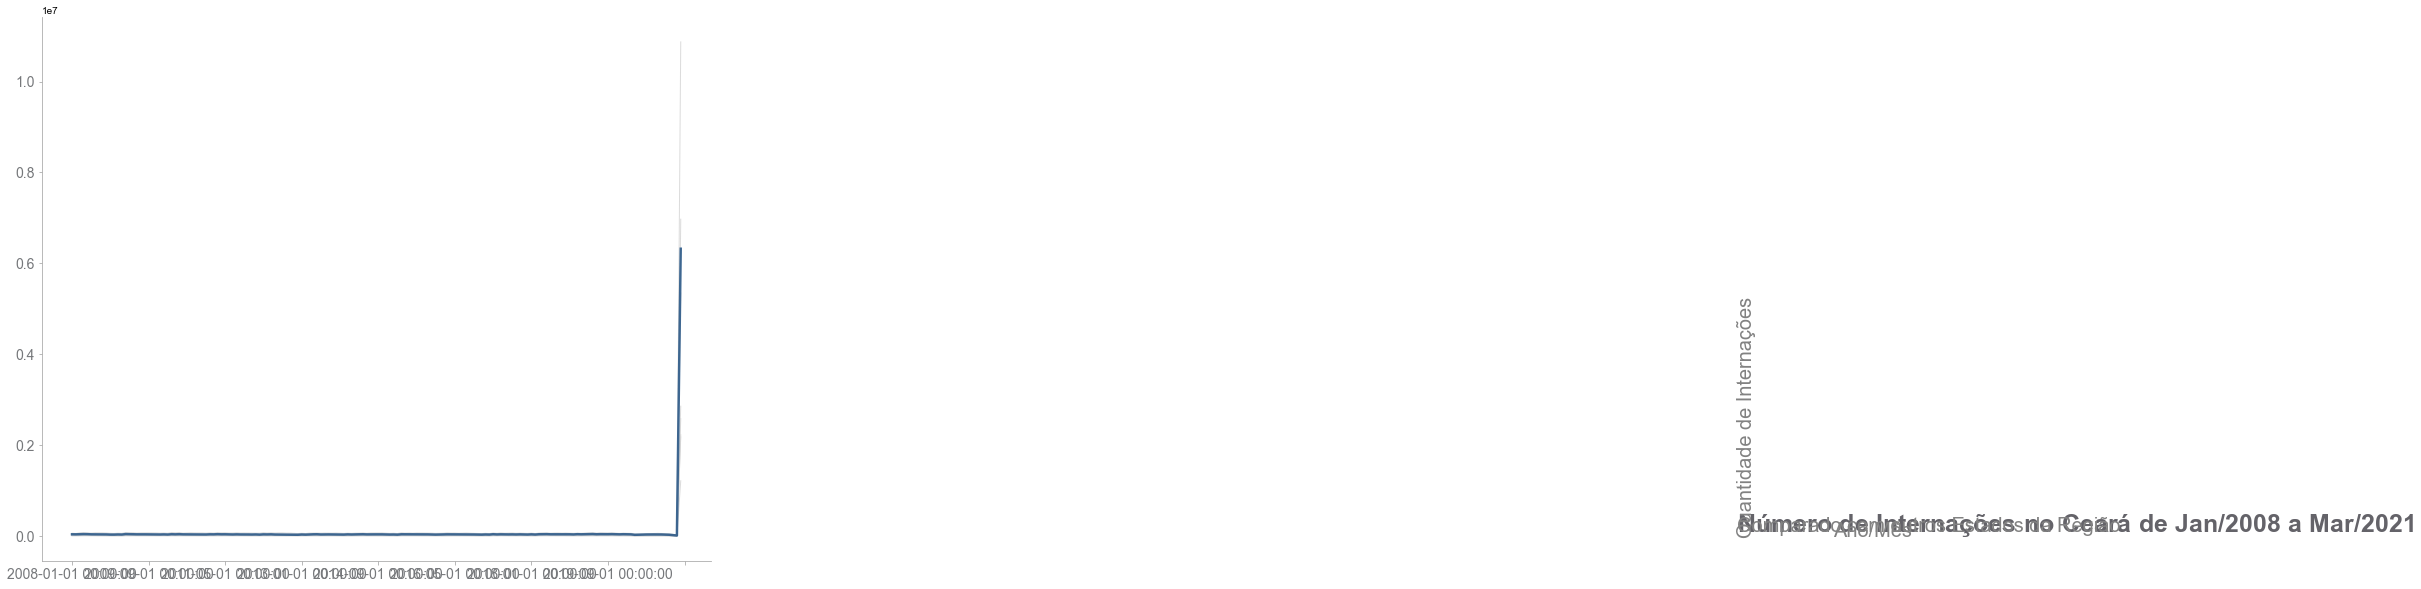

In [29]:
plt.figure(figsize = (12, 10))

for estado in internacoes_nordeste.index.tolist():
    ax = internacoes_nordeste.loc[estado].T.plot(color = 'lightgrey', linewidth = 1, alpha = 0.8)

ax = internacoes_nordeste.loc['23 Ceará'].T.plot(color = BLUE1, linewidth = 2.5, alpha = 0.8)

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(435, 90999, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(435, 86999, 'Comparado com outros Estados da Região',
         fontsize = 20, color = GRAY6)

plt.text(435, 47000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(460, -9000, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.show()

Novamente não considerando os últimos meses por não estarem totalmente atualizados, percebemos que as internações mantém certa estabilidade ao passar dos anos, mas também notamos que existem períodos de alta e baixa, e uma sazonalidade.

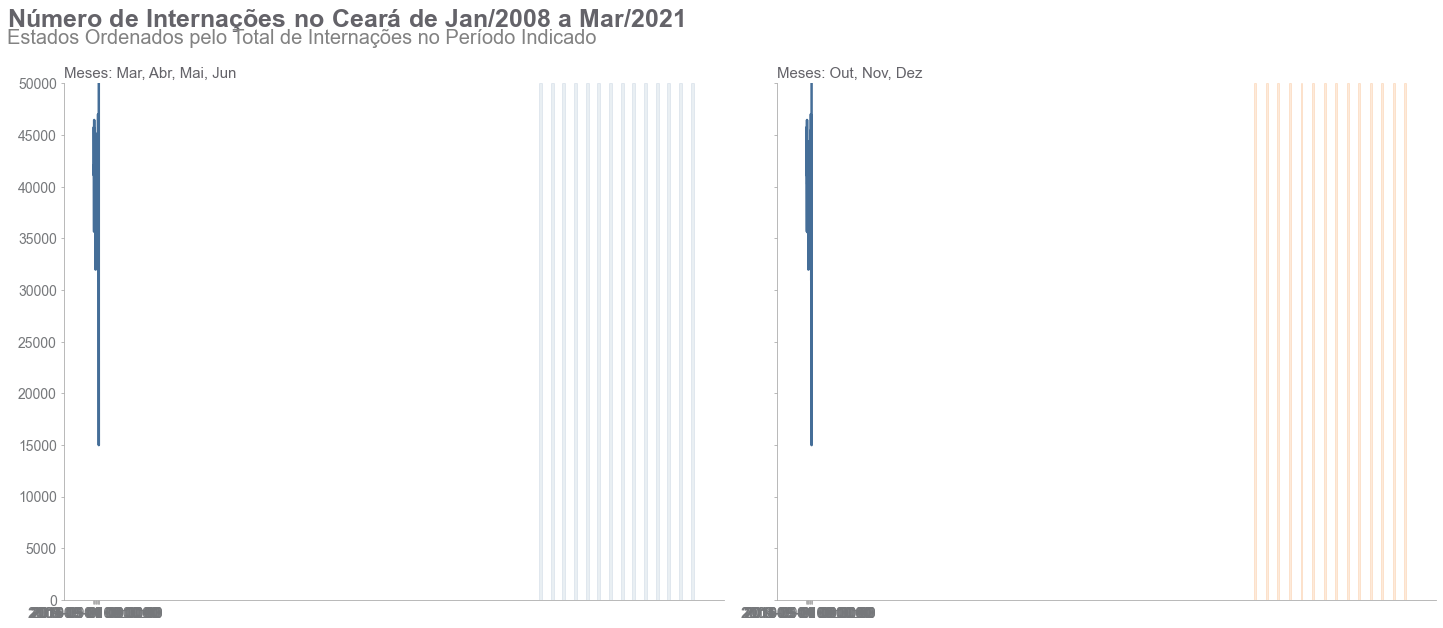

In [30]:
fig, axes = plt.subplots(1, 2, sharex = False, sharey = True, figsize = (20, 8))

fig.text(0, 1.05, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

fig.text(0, 1.02, 'Estados Ordenados pelo Total de Internações no Período Indicado',
         fontsize = 20, color = GRAY6)

#fig.text(0.085, 0.71, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
#fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

internacoes_nordeste.loc['23 Ceará'].T.plot(ax = axes[0], color = BLUE1, linewidth = 2.5, alpha = 0.8)
internacoes_nordeste.loc['23 Ceará'].T.plot(ax = axes[1], color = BLUE1, linewidth = 2.5, alpha = 0.8)

plt.ylim(0, 50000)
axes[0].set_yticks(range(0, 50001, 5000))

for i in [0, 1]:
    axes[i].tick_params(color = 'darkgrey')
    axes[i].spines['bottom'].set_color('darkgrey')
    axes[i].spines['left'].set_color('darkgrey')
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    for k in axes[i].get_yticklabels() + axes[i].get_xticklabels():
        k.set_fontsize(14)
        k.set_color(GRAY5)

#for mes in range(0, 160, 12):
#    axes[0].axvspan(mes + 2, mes + 5, alpha = 0.2, facecolor = BLUE4)
    
#for mes in range(0, 160, 12):
#    axes[1].axvspan(mes + 9, mes + 12, alpha = 0.2, facecolor = ORANGE1)

anos = []
for valor in range(2008, 2022):
    anos.append(valor)

for ano in range(len(anos)):
    axes[0].axvspan(datetime(anos[ano],3,1), datetime(anos[ano],6,1), color = BLUE4, alpha = 0.2)
    axes[1].axvspan(datetime(anos[ano],10,1), datetime(anos[ano],12,1), color = ORANGE1, alpha = 0.2)
    

axes[0].set_title('Meses: Mar, Abr, Mai, Jun', loc = 'left', fontsize = 15, color = GRAY4)
axes[1].set_title('Meses: Out, Nov, Dez', loc = 'left', fontsize = 15, color = GRAY4)

fig.tight_layout()
    
plt.show()

Novamente desconsiderando o período dos anos de 2020 e 2021 por estarem incompletos, observamos que as altas de internações ocorrem nos meses . . . 

In [31]:
internacoes_nordeste[:125].T.mean()[2]

79029.275

In [32]:
internacoes_nordeste[internacoes_nordeste.columns[:144]].T.mean()

29 Bahia                 69863.02
26 Pernambuco            44355.60
23 Ceará                 40284.90
21 Maranhão              33972.97
22 Piauí                 18342.48
25 Paraíba               16678.94
27 Alagoas               14285.56
24 Rio Grande do Norte   13852.40
28 Sergipe                7784.01
dtype: float64

## Conclusões

# Número de Internações por Município do Ceará - Por Local de Internação

Vamos agora comparar o número de internações no Ceará, focando em Fortaleza, e comparando a capital com os demais municícpios do Estado.

Aqui vale uma ressalva:

Para analisar esse dado, existe a opção de contabilizar o município onde o paciente foi internado, ou o município onde o paciente reside. Esses dois casos nem sempre dão os mesmos valores, pois muitas vezes pessoas que residem em municípios menos favorecidos, internam-se na capital, pois é onde estão grande parte dos hospitais.

Faremos uma breve comparação desses dois casos para vermos se existe mesmo uma grande disparidade entre esses dados.

## Importação e Limpeza dos Dados

In [33]:
# número de internações por município do Ceará por local de internação
intern_munic_local_raw = pd.read_csv('data/intern_muni_ce_por_local_de_internacao.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

FileNotFoundError: [Errno 2] No such file or directory: 'data/intern_muni_ce_por_local_de_internacao.csv'

In [ ]:
intern_munic_local_raw.head(3)

Vamos limpar um pouco esses dados.

In [ ]:
# cópia do dataframe original
intern_munic_local = intern_munic_local_raw.copy()

# remover os 6 números iniciais dos nomes dos municípios
intern_munic_local['Município'] = intern_munic_local['Município'].str[7:]

# coloca a coluna Município como índice
intern_munic_local = intern_munic_local.set_index('Município').rename_axis(None)

intern_munic_local.columns

Vemos que as 8 primeiras colunas correspondem ao ano de 2007. Vamos removê-las, pois começaremos nossas análises a partir de Janeiro de 2008.

In [ ]:
intern_munic_local = intern_munic_local[intern_munic_local.columns[8:]]
intern_munic_local.head(3)

In [ ]:
intern_munic_local.info()

Temos 159 colunas do tipo ```object```.

Já sabemos pelo site que o hífen nos dados equivale a _"Dado numérico igual a 0 não resultante de arredondamento."_

Vamos então fazer a substituição.

In [ ]:
intern_munic_local = intern_munic_local.replace('-', 0)

In [ ]:
intern_munic_local.info()

Mesmo realizando a substituição por zero, as colunas continuaram como ```object```. Vamos forçá-las a virarem do tipo numérico.

In [ ]:
intern_munic_local = intern_munic_local.apply(pd.to_numeric, errors = 'coerce')

In [ ]:
intern_munic_local.info()

Agora sim, todas as nossas colunas estão como ```int64``` e podemos analisá-las.

In [ ]:
intern_munic_local.columns

Temos uma coluna 'Total'. Vamos removê-la e, caso necessário, podemos somar novamente os valores para obtê-la.

In [ ]:
intern_munic_local = intern_munic_local.drop('Total', axis = 1)

Como queremos analisar e comparar Fortaleza com todos os outros municípios do Estado, precisamos apenas dos dados de Fortaleza e iremos juntar os dados dos outros municípios em um só.

In [ ]:
intern_munic_local.head()

Para isso, podemos somar todos as colunas de todos os municípios exceto Fortaleza.

In [ ]:
# convertendo o "Ano/Mês" para datetime
intern_munic_local.columns = pd.to_datetime(intern_munic_local.columns, format='%Y/%b')

In [ ]:
intern_munic_local = intern_munic_local.T

In [ ]:
intern_munic_local['Soma'] = intern_munic_local.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [ ]:
intern_munic_local = intern_munic_local[['Fortaleza', 'Soma']]

In [ ]:
intern_munic_local

Agora temos um dataframe com apenas duas colunas, uma correspondendo à Fortaleza e outra correnspondendo à soma de todos os outros municípios.

## Análise Gráfica

In [ ]:
color = [BLUE1, ORANGE1]

ax = intern_munic_local.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.set_yticks(range(0, 30001, 5000))

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(442, 35000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(442, 33000, 'Internações contabilizadas por local de internação',
         fontsize = 20, color = GRAY6)

plt.text(442, 15000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -4500, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(615, 5500, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(615, 18000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

## Conclusões

# Número de Internações por Município do Ceará - Por Local de Residência

## Importação & Limpeza dos Dados

In [ ]:
# número de internações por município do Ceará por local de residência
intern_munic_resid_raw = pd.read_csv('data/intern_muni_ce_por_local_de_residencia.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [ ]:
intern_munic_resid_raw.head(3)

Vamos limpar um pouco esses dados.

In [ ]:
# cópia do dataframe original
intern_munic_resid = intern_munic_resid_raw.copy()

# remover os 6 números iniciais dos nomes dos municípios
intern_munic_resid['Município'] = intern_munic_resid['Município'].str[7:]

# coloca a coluna Município como índice
intern_munic_resid = intern_munic_resid.set_index('Município').rename_axis(None)

intern_munic_resid.columns

Vemos que as 8 primeiras colunas correspondem ao ano de 2007. Vamos removê-las, pois começaremos nossas análises a partir de Janeiro de 2008.

In [ ]:
intern_munic_resid = intern_munic_resid[intern_munic_resid.columns[8:]]
intern_munic_resid.head(3)

In [ ]:
intern_munic_resid.info()

Aqui temos apenas uma coluna do tipo ```object```. Vamos encontrá-la.

In [ ]:
intern_munic_resid.select_dtypes(object).head()

Então provavelmente temos algum valor faltante na coluna '2021/Mar'. Isso condiz com o que viemos falando até aqui, que os valores dos últimos meses ainda não estão completos.

In [ ]:
intern_munic_resid = intern_munic_resid.replace('-', 0)

In [ ]:
intern_munic_resid['2021/Mar'] = intern_munic_resid['2021/Mar'].astype('int64')

In [ ]:
intern_munic_resid.info()

Agora temos todas as colunas do tipo ```int64```.

In [ ]:
intern_munic_resid.columns

Ainda temos uma coluna 'Total', iremos removê-la.

In [ ]:
intern_munic_resid = intern_munic_resid.drop('Total', axis = 1)

Agora só nos resta separar o dataframe em duas colunas: Fortaleza e Outros Municípios.

In [ ]:
# convertendo o "Ano/Mês" para datetime
intern_munic_resid.columns = pd.to_datetime(intern_munic_resid.columns, format='%Y/%b')

In [ ]:
intern_munic_resid = intern_munic_resid.T

In [ ]:
intern_munic_resid['Soma'] = intern_munic_resid.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [ ]:
intern_munic_resid = intern_munic_resid[['Fortaleza', 'Soma']]

In [ ]:
intern_munic_local

Pronto, já temos o que queríamos e podemos analisar graficamente.

## Análise Gráfica

In [ ]:
color = [BLUE1, ORANGE1]

ax = intern_munic_resid.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.set_yticks(range(0, 35001, 5000))

ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(442, 39000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(442, 37000, 'Internações contabilizadas por local de residência',
         fontsize = 20, color = GRAY6)

plt.text(442, 15000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -4500, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(615, 5500, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(615, 18000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

Aqui a diferença é maior, pois local de residência . . .

## Conclusões

# Conclusão Parcial

Região que mais gasta... porcentagens?

Estado do Nordeste que mais gasta... porcentagens?

Cidade do Ceará que mais gasta... porcentagens?


# Total de Gastos com Internação - Brasil

Agora vamos avaliar e analisar o valor total utilizado por internações para vermos se há alguma relação com o número de internações de cada local.

## Importação & Limpeza dos Dados

In [ ]:
valor_total_br = pd.read_csv('data/valor_total_brasil.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [ ]:
valor_total_br.head(3)

Hora de limpar esses dados!

In [ ]:
# cópia do dataframe original
valortotalbr = valor_total_br.copy()

# remover os números dos nomes das UFs
# podemos fazer isso pois usamos outro método pra separar por regiões
valortotalbr['Unidade da Federação'] = valortotalbr['Unidade da Federação'].str[3:]

# colocando a coluna de UFs como índice
valortotalbr = valortotalbr.set_index('Unidade da Federação').rename_axis(None)

Vamos encontrar em qual posição está a coluna '2008/Jan' e fazer um slice para nosso dataframe iniciar a partir dela.

In [ ]:
valortotalbr.columns.get_loc('2008/Jan')

In [ ]:
# fazendo o slicing
valortotalbr = valortotalbr[valortotalbr.columns[126:]]

In [ ]:
valortotalbr.head(3)

Será que todos os valores estão completos? Vamos conferir!

In [ ]:
valortotalbr.info()

Todas as colunas são do tipo ```float64```, então não temos nenhum valor que foi subsituído por hífen ou algo do tipo. Ainda bem!

Vamos remover a coluna 'Total'. Caso precisemos do total dos valores, podemos facilmente somá-los.

In [ ]:
valortotalbr = valortotalbr.drop('Total', axis = 1)

Finalmente, vamos converter as colunas para o formato de data.

In [ ]:
valortotalbr.columns = pd.to_datetime(valortotalbr.columns, format = '%Y/%b')

In [ ]:
valortotalbr.head(3)

Agora parece que está tudo certo e podemos começar a analisar graficamente.

## Análise Gráfica

In [ ]:
# separar por regiões

norte = valortotalbr.index[:7].tolist()
nordeste = valortotalbr.index[7:16].tolist()
sudeste = valortotalbr.index[16:20].tolist()
sul = valortotalbr.index[20:23].tolist()
centro_oeste = valortotalbr.index[23:].tolist()

In [ ]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (25, 15))

fig.text(0.085, 0.95, '$\\bf{Número\ de\ Internações\ por\ Região\ do\ Brasil\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)

# foi necessário dar um limite para o eixo y pois os gastos do sudeste
# possuem um pico muito elevado no início que estava deturpando a plotagem
plt.ylim(0, 400000000)

axes[1, 2].set_visible(False)

valortotalbr.loc[norte].T.plot(ax = axes[0, 0], colormap = 'tab10')
axes[0, 0].set_title('Região Norte', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
axes[0, 0].spines['bottom'].set_color('darkgrey')
axes[0, 0].spines['left'].set_color('darkgrey')
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['top'].set_visible(False)

valortotalbr.loc[nordeste].T.plot(ax = axes[0, 1], colormap = 'Set1')
axes[0, 1].set_title('Região Nordeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 1].spines['bottom'].set_color('darkgrey')
axes[0, 1].spines['left'].set_color('darkgrey')
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['top'].set_visible(False)

valortotalbr.loc[sudeste].T.plot(ax = axes[0, 2], colormap = 'cool')
axes[0, 2].set_title('Região Sudeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[0, 2].spines['bottom'].set_color('darkgrey')
axes[0, 2].spines['left'].set_color('darkgrey')
axes[0, 2].spines['right'].set_visible(False)
axes[0, 2].spines['top'].set_visible(False)

valortotalbr.loc[sul].T.plot(ax = axes[1, 0], colormap = 'Dark2')
axes[1, 0].set_title('Região Sul', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 0].spines['bottom'].set_color('darkgrey')
axes[1, 0].spines['left'].set_color('darkgrey')
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['top'].set_visible(False)

valortotalbr.loc[centro_oeste].T.plot(ax = axes[1, 1], colormap = 'hsv')
axes[1, 1].set_title('Região Centro-Oeste', loc = 'left', fontsize = 19, color = GRAY4)
axes[1, 1].spines['bottom'].set_color('darkgrey')
axes[1, 1].spines['left'].set_color('darkgrey')
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['top'].set_visible(False)

axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

plt.show()

Conclusões: . . .

Vamos agora ver o total por região.

In [ ]:
valor_total_regioes = valortotalbr.copy()
valor_total_regioes = valor_total_regioes.T

valor_total_regioes['Nordeste'] = valor_total_regioes[nordeste].sum(axis = 1)
valor_total_regioes['Norte'] = valor_total_regioes[norte].sum(axis = 1)
valor_total_regioes['Sudeste'] = valor_total_regioes[sudeste].sum(axis = 1)
valor_total_regioes['Sul'] = valor_total_regioes[sul].sum(axis = 1)
valor_total_regioes['Centro_Oeste'] = valor_total_regioes[centro_oeste].sum(axis = 1)

valor_total_regioes = valor_total_regioes[['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_Oeste']]

valor_total_regioes.head()

In [ ]:
ax = valor_total_regioes.plot(figsize = (15, 10))

# foi necessário dar um limite para o eixo y pois os gastos do sudeste
# possuem um pico muito elevado no início que estava deturpando a plotagem
plt.ylim(0, 700000000)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(430, 750000000, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 20, color = GRAY4)
plt.text(430, 730000000, 'Comparado com outros Estados da Região',
         fontsize = 18, color = GRAY6)

plt.text(430, 400000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -50000000, 'Ano/Mês', fontsize = 20, color = GRAY6)

plt.text(615, 600000000, 'Sudeste', fontsize = 18, color = 'green')
plt.text(615, 350000000, 'Nordeste', fontsize = 18, color = 'blue')
plt.text(615, 100000000, 'Sul', fontsize = 18, color = 'red')
plt.text(615, 50000000, 'Norte', fontsize = 18, color = 'orange')
plt.text(615, 30000000, 'Centro-Oeste', fontsize = 18, color = 'purple')

ax.get_legend().remove()

plt.show()

## Conslusões

Conclusões: . . .

os valores de norte e centro-oeste são extremamente parecidos!

In [ ]:
valor_total_nordeste = valortotalbr.copy()

valor_total_nordeste = valor_total_nordeste.loc[nordeste]

valor_total_nordeste['Soma'] = valor_total_nordeste.sum(axis = 1)

valor_total_nordeste = valor_total_nordeste.sort_values(by = 'Soma', ascending = False)

valor_total_nordeste = valor_total_nordeste.drop('Soma', axis = 1)

In [ ]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (25, 20))

palette = plt.get_cmap('tab10')

fig.text(0.070, 0.95, '$\\bf{Valor\ Total\ por\ Estado\ da\ Região\ Nordeste\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
fig.text(0.070, 0.933, 'Estados Ordenados pelo Total de Internações no Período',
         fontsize = 20, color = GRAY6)

fig.text(0.070, 0.72, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY4)
fig.text(0.12, 0.09, 'Ano/Mês', fontsize = 20, color = GRAY4)

num = 0

for estado in valor_total_nordeste.index.tolist():
    num += 1
    plt.subplot(3, 3, num)
    ax = valor_total_nordeste.loc[estado].T.plot(color = palette(num))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
    plt.ylim(0, 100000000)
    if num in range(7) :
        plt.tick_params(labelbottom = False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft = False)
    plt.title(estado, loc = 'left', fontsize = 19, color = GRAY4)
    
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(10)
        i.set_color(GRAY4)
    
    ax.tick_params(color = 'darkgrey', bottom = True)
    ax.spines['bottom'].set_color('darkgrey')
    ax.spines['left'].set_color('darkgrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#plt.suptitle("Número de Internações por Estado da Região Nordeste de Jan/2008 a Mar/2021\nOrdenados pelo Total de Gastos",
#             fontsize = 20, fontweight = 5, color = GRAY4, style = 'italic', y = 0.95, x = 0.1, ha = 'left')

plt.show()

In [ ]:
plt.figure(figsize = (12, 10))

for estado in valor_total_nordeste.index.tolist():
    ax = valor_total_nordeste.loc[estado].T.plot(color = 'lightgrey', linewidth = 1, alpha = 0.8)

ax = valor_total_nordeste.loc['Ceará'].T.plot(color = BLUE1, linewidth = 2.5, alpha = 0.8)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_yticks(range(0, 90000001, 10000000))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)


plt.text(425, 100000000, '$\\bf{Número\ de\ Internações\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(425, 96000000, 'Comparado com outros Estados da Região',
         fontsize = 20, color = GRAY6)

plt.text(425, 50000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -10000000, 'Período', fontsize = 20, color = GRAY6)

plt.show()

# Total de Gastos por Município do Ceará

## Importação & Limpeza dos Dados

In [ ]:
valor_total_municipios_ceara = pd.read_csv('data/valor_total_municipios_ceara.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3,
                            skipfooter = 13, thousands = '.', decimal = ',', engine = 'python')

In [ ]:
valor_total_municipios_ceara.head(3)

In [ ]:
# cópia do dataframe original
valor_total_muni_ce = valor_total_municipios_ceara.copy()

# remover os 6 números iniciais dos nomes dos municípios
valor_total_muni_ce['Município'] = valor_total_muni_ce['Município'].str[7:]

# coloca a coluna Município como índice
valor_total_muni_ce = valor_total_muni_ce.set_index('Município').rename_axis(None)

valor_total_muni_ce.head(3)

In [ ]:
valor_total_muni_ce.columns.get_loc('2008/Jan')

In [ ]:
valor_total_muni_ce = valor_total_muni_ce[valor_total_muni_ce.columns[12:]]
valor_total_muni_ce.head(3)

In [ ]:
valor_total_muni_ce.info()

In [ ]:
valor_total_muni_ce = valor_total_muni_ce.replace('-', 0)

In [ ]:
valor_total_muni_ce.info()

In [ ]:
valor_total_muni_ce = valor_total_muni_ce.apply(pd.to_numeric, errors = 'coerce')

In [ ]:
valor_total_muni_ce.info()

In [ ]:
valor_total_muni_ce.columns

In [ ]:
valor_total_muni_ce = valor_total_muni_ce.drop('Total', axis = 1)

In [ ]:
valor_total_muni_ce.columns = pd.to_datetime(valor_total_muni_ce.columns, format = '%Y/%b')

In [ ]:
valor_total_muni_ce.head(3)

In [ ]:
valor_total_muni_ce = valor_total_muni_ce.T

In [ ]:
valor_total_muni_ce['Soma'] = valor_total_muni_ce.drop(['Fortaleza'], axis = 1).sum(axis = 1)

In [ ]:
valor_total_muni_ce = valor_total_muni_ce[['Fortaleza', 'Soma']]

In [ ]:
valor_total_muni_ce

## Análise Gráfica

In [ ]:
color = [BLUE1, ORANGE1]

ax = valor_total_muni_ce.plot(alpha = 0.8, figsize = (15, 8), color = color, legend = None, linewidth = 2)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_yticks(range(0, 40000001, 5000000))
ax.tick_params(color = 'darkgrey')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(14)
    i.set_color(GRAY5)
    
# número de internações por município do Ceará por local de internação
    
plt.text(433, 45000000, '$\\bf{Número\ de\ Internações\ por\ Município\ no\ Ceará\ de\ Jan/2008\ a\ Mar/2021}$',
         fontsize = 25, color = GRAY4)
plt.text(433, 43000000, 'Internações contabilizadas por local de internação',
         fontsize = 20, color = GRAY6)

plt.text(433, 19000000, 'Quantidade de Internações', fontsize = 20, rotation = 'vertical', color = GRAY6)
plt.text(455, -3500000, 'Período', fontsize = 20, color = GRAY6)

plt.text(613, 25000000, 'Fortaleza', fontsize = 20, color = BLUE1)
plt.text(614, 12000000, 'Outros Municípios', fontsize = 20, color = ORANGE1)

plt.show()

In [ ]:
## Conclusões

Conclusão: Fortaleza gasta mais com menos internações.

## Conclusão Geral